In [1]:
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from sklearn.preprocessing import FunctionTransformer, PowerTransformer, RobustScaler
from sklearn.impute import SimpleImputer
from matplotlib import cm

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error
import seaborn as sns

import sys
sys.path.insert(0, '../scr')
from transformers import Impute, select_city,create_lag_sum_column,create_lagged_column, logtransform_target, inverse_logtransform_target,deal_with_missing_values, create_min_yearly_temp

### Load the provided data

In [2]:
train_features = pd.read_csv('../data/dengue_features_train.csv',
                             index_col=[0,1,2])
train_labels = pd.read_csv('../data/dengue_labels_train.csv',
                           index_col=[0,1,2])
test_features = pd.read_csv('../data/dengue_features_test.csv',
                             index_col=[0,1,2])

### Splitting the provided training data by city and into train and validation data for each city

In [3]:
# initialize dictionaries to hold the train and validation data for each city
full_train_X = {}
test_X = {}
train_X = {}
validate_X = {}
full_train_y = {}
train_y = {}
validate_y = {}
cities = ['sj', 'iq']
city_names = {'sj':'San Juan, Puerto Rico', 'iq':'Iquitos, Peru' }

# make the train validation split
for city in cities:
    full_train_X [city] = select_city(train_features, city = city)
    full_train_y [city] = select_city(train_labels, city = city)
    test_X [city] = select_city(test_features, city = city)
    
    assert len(full_train_X [city]) == len(full_train_y [city])
    
    split_idx = int(len(full_train_X[city])*0.8)
    
    train_X [city] = full_train_X [city].head(split_idx)
    train_y [city] = full_train_y [city].head(split_idx)
    
    validate_X [city] = full_train_X [city].tail(len(full_train_X[city]) - split_idx)
    validate_y [city] = full_train_y [city].tail(len(full_train_y[city]) - split_idx)
    

Check that the split worked

In [4]:
for city in cities:
    print('------------- '+city_names[city]+' -----------------')
    print("training")
    print('X', train_X[city].shape, 'y', train_y[city].shape)
    print('validation')
    print('X', validate_X[city].shape, 'y', validate_y[city].shape)
    print('all')
    print('X', full_train_X[city].shape, 'y', full_train_y[city].shape,'\n')

------------- San Juan, Puerto Rico -----------------
training
X (748, 21) y (748, 1)
validation
X (188, 21) y (188, 1)
all
X (936, 21) y (936, 1) 

------------- Iquitos, Peru -----------------
training
X (416, 21) y (416, 1)
validation
X (104, 21) y (104, 1)
all
X (520, 21) y (520, 1) 



### Select which features we want to look at time-lagged

In [5]:


myfeatures = [x for x in train_X['sj'].columns if x!='week_start_date']

In [6]:
extended_train_X = train_X.copy()

for city in cities:
    extended_train_X[city]['total_cases'] = train_y[city].total_cases
    for feat in myfeatures:
        for l in range(0,54):
            extended_train_X[city] = create_lagged_column(extended_train_X[city],feat,lag=l)
            extended_train_X[city] = create_lag_sum_column(extended_train_X[city],feat,lag=l)

    
#hlp['target']=train_y['sj']
#    corr[city]=hlp.corr()


/tmp/ipykernel_237305/1466237033.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extended_train_X[city]['total_cases'] = train_y[city].total_cases


In [9]:
for col in extended_train_X['sj'].columns:
    print(col)

week_start_date
ndvi_ne
ndvi_nw
ndvi_se
ndvi_sw
precipitation_amt_mm
reanalysis_air_temp_k
reanalysis_avg_temp_k
reanalysis_dew_point_temp_k
reanalysis_max_air_temp_k
reanalysis_min_air_temp_k
reanalysis_precip_amt_kg_per_m2
reanalysis_relative_humidity_percent
reanalysis_sat_precip_amt_mm
reanalysis_specific_humidity_g_per_kg
reanalysis_tdtr_k
station_avg_temp_c
station_diur_temp_rng_c
station_max_temp_c
station_min_temp_c
station_precip_mm
total_cases
ndvi_ne_lagged_0.00
ndvi_ne_sum_0.00
ndvi_ne_lagged_1.00
ndvi_ne_sum_1.00
ndvi_ne_lagged_2.00
ndvi_ne_sum_2.00
ndvi_ne_lagged_3.00
ndvi_ne_sum_3.00
ndvi_ne_lagged_4.00
ndvi_ne_sum_4.00
ndvi_ne_lagged_5.00
ndvi_ne_sum_5.00
ndvi_ne_lagged_6.00
ndvi_ne_sum_6.00
ndvi_ne_lagged_7.00
ndvi_ne_sum_7.00
ndvi_ne_lagged_8.00
ndvi_ne_sum_8.00
ndvi_ne_lagged_9.00
ndvi_ne_sum_9.00
ndvi_ne_lagged_10.00
ndvi_ne_sum_10.00
ndvi_ne_lagged_11.00
ndvi_ne_sum_11.00
ndvi_ne_lagged_12.00
ndvi_ne_sum_12.00
ndvi_ne_lagged_13.00
ndvi_ne_sum_13.00
ndvi_ne_lagged_1

In [10]:
corr={}
for city in cities:
    corr[city] = extended_train_X[city].corr()['total_cases']
corr['iq'] = corr['iq'].rolling(3,center=True).mean()

In [15]:
corr['iq']['ndvi_ne_lagged_0.00']

0.3438465038111134

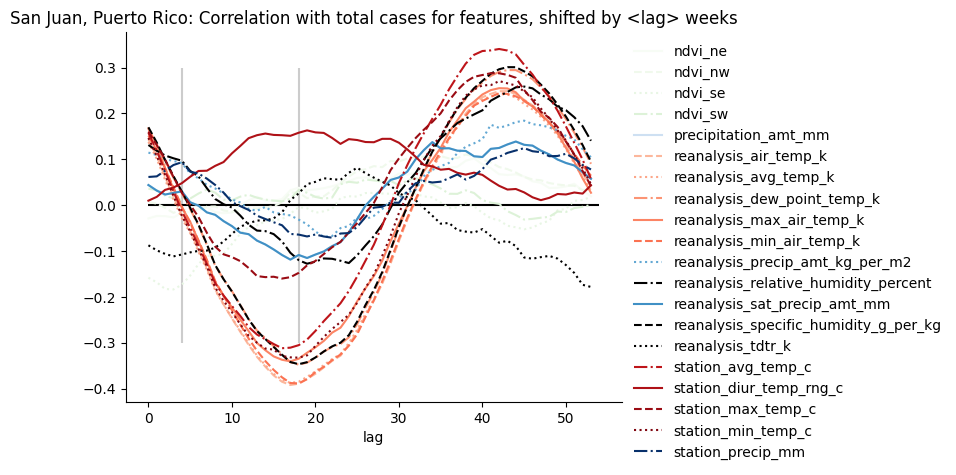

In [27]:
cmap = cm.get_cmap('Reds')
temp_colors = cmap(np.linspace(0,1,20))
cmap = cm.get_cmap('Blues')
preci_colors = cmap(np.linspace(0,1,20))
cmap = cm.get_cmap('Greens')
ndvi_colors = cmap(np.linspace(0,1,20))
style=['-','--',':','dashdot']*5
i=0
city='sj'
for feature in myfeatures:
    data=[]
    for l in range(0,54):
        data.append([l,corr[city][feature+f'_lagged_{l:1.2f}']])
    data=np.array(data)
    if 'temp' in feature:
        color=temp_colors[i]
    elif 'preci' in feature:
        color=preci_colors[i]
    elif 'ndvi' in feature:
        color=ndvi_colors[i]
    else:
        color='k'
    plt.plot(data[:,0],data[:,1],label=feature,color=color,ls=style[i])
    i+=1
plt.gca().set_xlabel('lag')
plt.gca().set_title(city_names[city]+': Correlation with total cases for features, shifted by <lag> weeks',)

plt.gca().legend(bbox_to_anchor=(1,1),frameon=False)
if city == 'iq':
    plt.gca().vlines([4,6],-0.3,0.3,color='.8')
else:
    plt.gca().vlines([4,18],-0.3,0.3,color='.8')
plt.gca().hlines([0],0,54)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

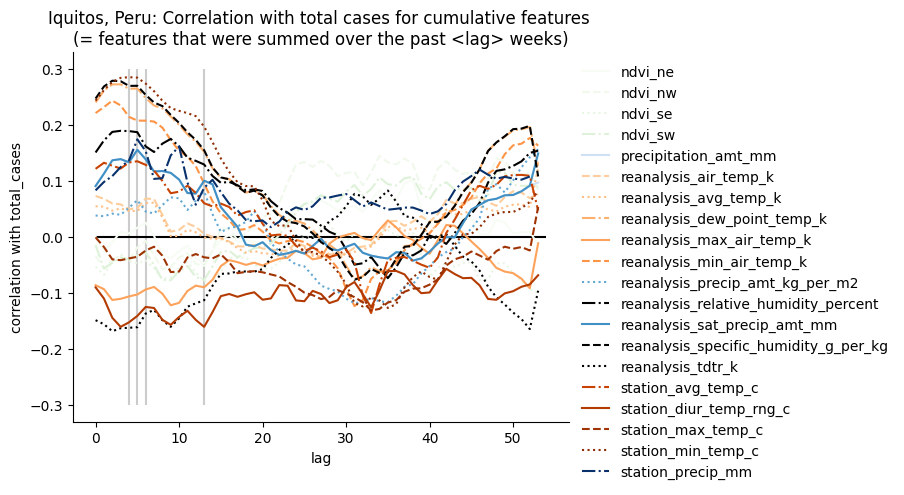

In [21]:
cmap = cm.get_cmap('Oranges')
temp_colors = cmap(np.linspace(0,1,20))
cmap = cm.get_cmap('Blues')
preci_colors = cmap(np.linspace(0,1,20))
cmap = cm.get_cmap('Greens')
ndvi_colors = cmap(np.linspace(0,1,20))
style=['-','--',':','dashdot']*5
i=0
city='iq'
for feature in myfeatures:
    data=[]
    for l in range(0,54):
        data.append([l,corr[city][feature+f'_sum_{l:1.2f}']])
    data=np.array(data)
    if 'temp' in feature:
        color=temp_colors[i]
    elif 'preci' in feature:
        color=preci_colors[i]
    elif 'ndvi' in feature:
        color=ndvi_colors[i]
    else:
        color='k'
    plt.plot(data[:,0],data[:,1],label=feature,color=color,ls=style[i])
    i+=1
plt.gca().set_xlabel('lag')
plt.gca().legend(bbox_to_anchor=(1,1),frameon=False)
plt.gca().set_title(city_names[city]+': Correlation with total cases for cumulative features \n(= features that were summed over the past <lag> weeks)',)

plt.gca().vlines([4,5,6,13],-0.3,0.3,color='0.8')
plt.gca().set_ylabel('correlation with total_cases')
plt.gca().hlines([0],0,54)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


In [ ]:
corr = extended_train_X['sj'].corr()['total_cases'].rolling(5).mean()
cmap = cm.get_cmap('Oranges')
temp_colors = cmap(np.linspace(0,1,20))
cmap = cm.get_cmap('Blues')
preci_colors = cmap(np.linspace(0,1,20))
cmap = cm.get_cmap('Greens')
ndvi_colors = cmap(np.linspace(0,1,20))
style=['-','--',':','dashdot']*5
i=0
for feature in myfeatures:
    data=[]
    for l in range(0,54):
        data.append([l,corr[feature+f'_sum_{l:1.2f}']])
    data=np.array(data)
    if 'temp' in feature:
        color=temp_colors[i]
    elif 'preci' in feature:
        color=preci_colors[i]
    elif 'ndvi' in feature:
        color=ndvi_colors[i]
    else:
        color='k'
    plt.plot(data[:,0],data[:,1],label=feature,color=color,ls=style[i])
    i+=1
plt.gca().set_xlabel('lag')
plt.gca().legend(bbox_to_anchor=(1,1),frameon=False)
plt.gca().set_title('SAN JUAN, Correlation with total cases for cumulative features \n(= features that were summed over the past <lag> weeks)',)

plt.gca().vlines([4,5,6,13],-0.3,0.3,color='0.8')
plt.gca().set_ylabel('correlation with total_cases')
plt.gca().hlines([0],0,54)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
